## Telecom Churn Prediction
- Train Three ML Models with different features combination:
      1) using all features  
      2) removing wieghted features  
      3) removing less important features 
 
- Compare Results

In [1]:
from utilties import *
from get_pred import *

In [2]:
sns.set()
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import warnings
import plotly.graph_objs as go
import plotly.offline as offline
offline.init_notebook_mode(connected = True)
warnings.filterwarnings("ignore")

pd.set_option("display.max_columns",None)
pd.set_option("display.max_rows",None)
pd.set_option('display.width', None)

In [3]:
import session_info
session_info.show()

## Get Data

In [45]:
df_data = pd.read_pickle('data/df_data.pkl')
df_val = pd.read_pickle('data/df_val_scaled.pkl')
df_data.shape

(2999, 28)

In [46]:
df_data.columns

Index(['night minutes', 'Duration', 'international minutes', 'night calls',
       'eve minutes', 'total day calls', 'international calls', 'vmail',
       'eve calls', 'Call day minutes', 'w_night minutes', 'w_Duration',
       'w_international minutes', 'w_night calls', 'w_eve minutes',
       'w_total day calls', 'w_international calls', 'w_vmail', 'w_eve calls',
       'w_Call day minutes', 'gender', 'SeniorCitizen',
       'Product: International', 'Product: Voice mail', 'Phone Code',
       'PaperlessBilling', 'service calls', 'churn'],
      dtype='object')

In [48]:
wieghted_feats = ['w_eve calls', 'w_eve minutes','w_night calls', 'w_total day calls', 'w_Duration', 'w_night minutes',
       'w_Call day minutes', 'w_international calls','w_international minutes', 'w_vmail']
less_imp_feats = ['gender' , 'Phone Code' , 'SeniorCitizen','Duration','w_night calls','night calls','w_Duration','eve calls',
                  'w_total day calls','total day calls','w_eve minutes']

## Steps involved
- Try models: 'dummy_classifier', 'k_nearest_neighbors','logistic_regression', 'support_vector_machines','random_forest', 'gradient_boosting'
- Select suitable model
- Tune Hyperparamters (max_depth, n_estimators, min_samples_split, min_samples_leaf, max_features)
- Find best Model 
- Analyse results

In [7]:
def Train_ML_Model(DF):
    X = DF.drop(columns='churn')
    y = DF.loc[:, 'churn']
    print(X.columns)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=40, shuffle=True)
    models = create_models()

    results = []
    names = []
    scoring = 'accuracy'
    for name, model in models:
        model.fit(X_train, y_train).predict(X_test)
        predictions = model.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        results.append(accuracy)
        names.append(name)
        print('Classifier: {}, Accuracy: {})'.format(name, accuracy))

    print('\n\n','-'*50,' Train RF Model', '-'*50)
    rfc = RandomForestClassifier(class_weight = 'balanced',random_state=100,n_jobs = -1)
    rfc.fit(X_train,y_train)
    Get_ROC(rfc, X_test, y_test)
    print('\n\n','-'*50,' Perform hyperparameter tuning wrt individual parameters', '-'*50)
    Tune_Single_Parameter(X_train, y_train, PAR_NAME= 'max_depth', 
                          PARAMETER={'max_depth': range(2, 25, 1)}, N_FOLD=5, TARGET="precision")
    Tune_Single_Parameter(X_train, y_train, PAR_NAME= 'n_estimators', 
                          PARAMETER={'n_estimators': [10,25,50,75,100]}, N_FOLD=5, TARGET="precision")
    Tune_Single_Parameter(X_train, y_train, PAR_NAME= 'min_samples_split', 
                          PARAMETER={'min_samples_split': range(10,200,10)}, N_FOLD=5, TARGET="precision")
    Tune_Single_Parameter(X_train, y_train, PAR_NAME= 'min_samples_leaf', 
                          PARAMETER={'min_samples_leaf': range(10,200,10)}, N_FOLD=3, TARGET="precision")
    Tune_Single_Parameter(X_train, y_train, PAR_NAME= 'max_features', 
                          PARAMETER={'max_features': range(5,16,3)}, N_FOLD=3, TARGET="precision")

    print('\n\n','-'*50,' Perform hyperparameter tuning ', '-'*50)
    param_grid = {
        'max_depth': [10,13,15,17,20],
        'min_samples_split': [5,10,15], 
        'min_samples_leaf': [5,8,11,14,17] }

    rf = RandomForestClassifier(class_weight = 'balanced',random_state=100)
    grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, #scoring='precision',
                              cv = 3, n_jobs = -1,verbose = 1,return_train_score=True)

    grid_search.fit(X_train, y_train)
    print(grid_search.best_score_)
    print(grid_search.best_params_)
    print('We can get accuracy of',grid_search.best_score_,'using',grid_search.best_params_)

    rf = RandomForestClassifier(bootstrap=True,random_state=100,
                                 max_depth=grid_search.best_params_['max_depth'],
                                 min_samples_split=grid_search.best_params_['min_samples_split'],
                                  class_weight='balanced')
    rf.fit(X_train,y_train)
    Get_ROC(rf, X_test, y_test)
    print('\n\n','-'*50,' Plot Feat importance  ', '-'*50)
    Get_RF_Model_Feat_Importance(rf, X_train.columns, len(X_train.columns))
    return rf, X_train.columns.to_list()

# Model 1 - Use all features

Index(['eve calls', 'eve minutes', 'night calls', 'total day calls',
       'Duration', 'night minutes', 'Call day minutes', 'international calls',
       'international minutes', 'vmail', 'w_eve calls', 'w_eve minutes',
       'w_night calls', 'w_total day calls', 'w_Duration', 'w_night minutes',
       'w_Call day minutes', 'w_international calls',
       'w_international minutes', 'w_vmail', 'gender', 'SeniorCitizen',
       'Product: International', 'Product: Voice mail', 'Phone Code',
       'PaperlessBilling', 'service calls'],
      dtype='object')
Classifier: dummy_classifier, Accuracy: 0.844)
Classifier: k_nearest_neighbors, Accuracy: 0.8626666666666667)
Classifier: logistic_regression, Accuracy: 0.8453333333333334)
Classifier: support_vector_machines, Accuracy: 0.8573333333333333)
Classifier: random_forest, Accuracy: 0.9413333333333334)
Classifier: gradient_boosting, Accuracy: 0.9493333333333334)


 --------------------------------------------------  Train RF Model ----------

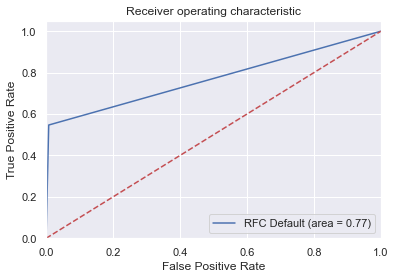

Area under curve is: 0.77
Recall for our model is: 0.55
Accuracy on test set is: 0.92
[[628   5]
 [ 53  64]]
              precision    recall  f1-score   support

           0       0.92      0.99      0.96       633
           1       0.93      0.55      0.69       117

    accuracy                           0.92       750
   macro avg       0.92      0.77      0.82       750
weighted avg       0.92      0.92      0.91       750



 --------------------------------------------------  Perform hyperparameter tuning wrt individual parameters --------------------------------------------------

Tuning max_depth
Fitting 5 folds for each of 23 candidates, totalling 115 fits
0.931336542899636
{'max_depth': 13}


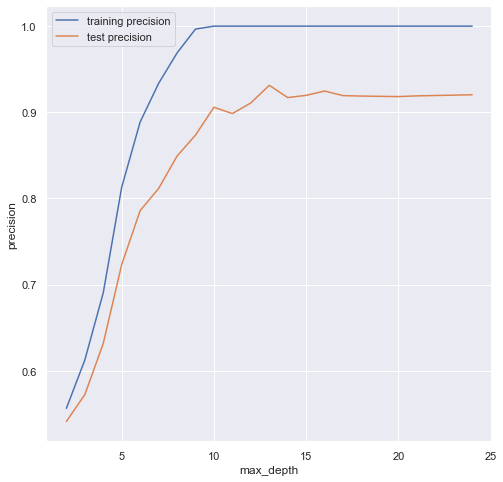


Tuning n_estimators
Fitting 5 folds for each of 5 candidates, totalling 25 fits
0.9203646580583452
{'n_estimators': 100}


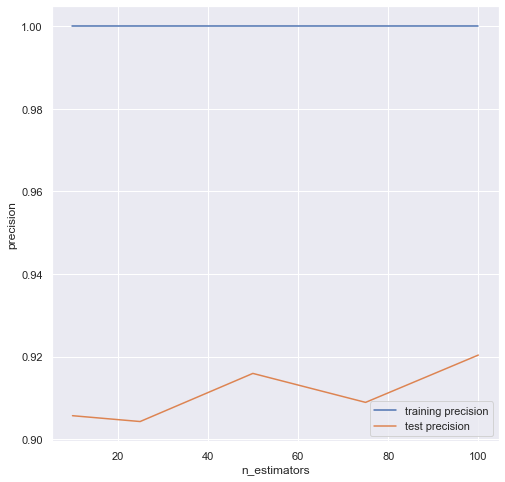


Tuning min_samples_split
Fitting 5 folds for each of 19 candidates, totalling 95 fits
0.8580992313067786
{'min_samples_split': 10}


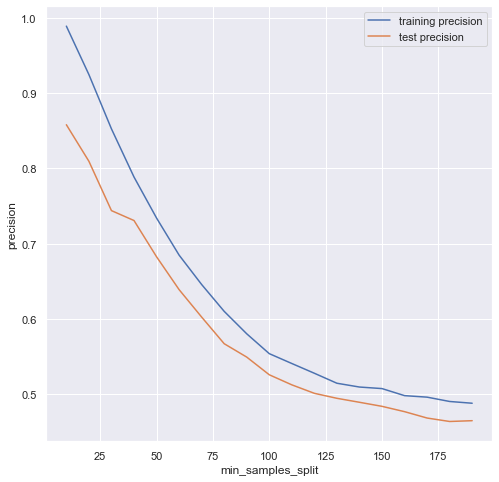


Tuning min_samples_leaf
Fitting 3 folds for each of 19 candidates, totalling 57 fits
0.7349421989664776
{'min_samples_leaf': 10}


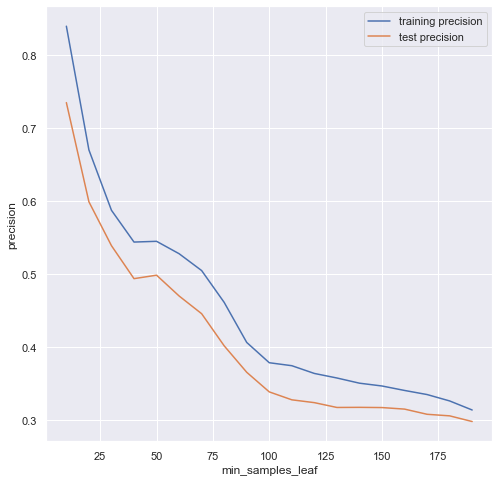


Tuning max_features
Fitting 3 folds for each of 4 candidates, totalling 12 fits
0.9370118417737464
{'max_features': 5}


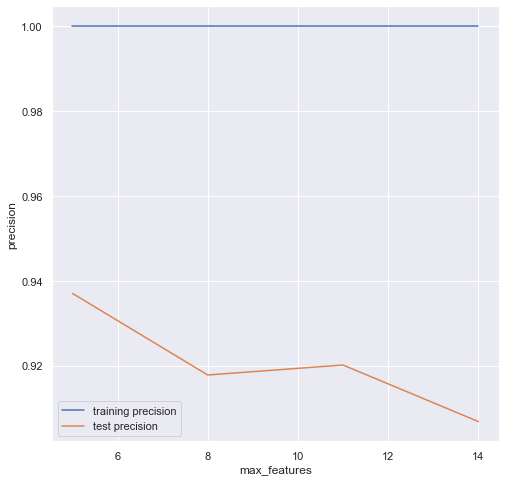



 --------------------------------------------------  Perform hyperparameter tuning  --------------------------------------------------
Fitting 3 folds for each of 75 candidates, totalling 225 fits
0.9364177421747515
{'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 15}
We can get accuracy of 0.9364177421747515 using {'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 15}


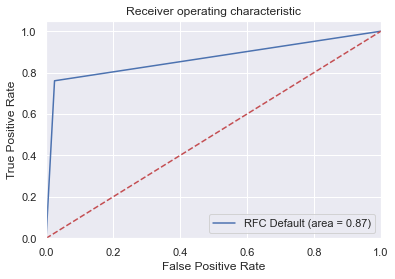

Area under curve is: 0.87
Recall for our model is: 0.76
Accuracy on test set is: 0.94
[[617  16]
 [ 28  89]]
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       633
           1       0.85      0.76      0.80       117

    accuracy                           0.94       750
   macro avg       0.90      0.87      0.88       750
weighted avg       0.94      0.94      0.94       750



 --------------------------------------------------  Plot Feat importance   --------------------------------------------------


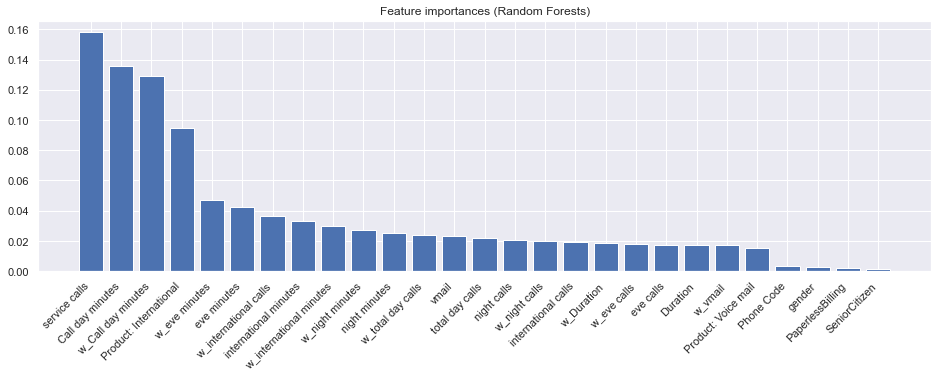

In [8]:
rf1, feats1 = Train_ML_Model(df_data)

## Impact of Hyperparameter Tuning
- Accuray increase
- AUC increase
- Recall increase

## Validation Results

In [66]:
Val_Pred(df_val,rf1)

Recall for our model is: 0.45
Accuracy on test set is: 0.85
[[2341  221]
 [ 239  198]]
              precision    recall  f1-score   support

           0       0.91      0.91      0.91      2562
           1       0.47      0.45      0.46       437

    accuracy                           0.85      2999
   macro avg       0.69      0.68      0.69      2999
weighted avg       0.84      0.85      0.85      2999



# Model 2 - Remove wieghted features

Index(['international calls', 'night minutes', 'Product: International',
       'Product: Voice mail', 'total day calls', 'service calls',
       'SeniorCitizen', 'Phone Code', 'international minutes', 'gender',
       'eve calls', 'Duration', 'Call day minutes', 'night calls', 'vmail',
       'PaperlessBilling', 'eve minutes'],
      dtype='object')
Classifier: dummy_classifier, Accuracy: 0.844)
Classifier: k_nearest_neighbors, Accuracy: 0.8613333333333333)
Classifier: logistic_regression, Accuracy: 0.8413333333333334)
Classifier: support_vector_machines, Accuracy: 0.856)
Classifier: random_forest, Accuracy: 0.9386666666666666)
Classifier: gradient_boosting, Accuracy: 0.9493333333333334)


 --------------------------------------------------  Train RF Model --------------------------------------------------


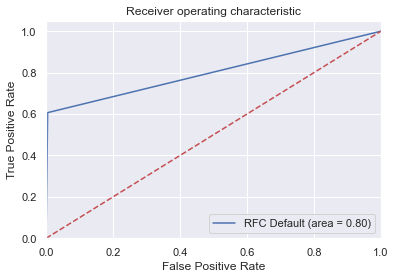

Area under curve is: 0.8
Recall for our model is: 0.61
Accuracy on test set is: 0.93
[[630   3]
 [ 46  71]]
              precision    recall  f1-score   support

           0       0.93      1.00      0.96       633
           1       0.96      0.61      0.74       117

    accuracy                           0.93       750
   macro avg       0.95      0.80      0.85       750
weighted avg       0.94      0.93      0.93       750



 --------------------------------------------------  Perform hyperparameter tuning wrt individual parameters --------------------------------------------------

Tuning max_depth
Fitting 5 folds for each of 23 candidates, totalling 115 fits
0.9529329585143538
{'max_depth': 17}


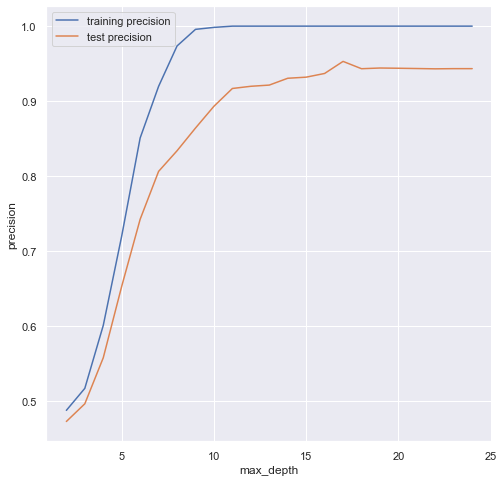


Tuning n_estimators
Fitting 5 folds for each of 5 candidates, totalling 25 fits
0.9434185056136275
{'n_estimators': 100}


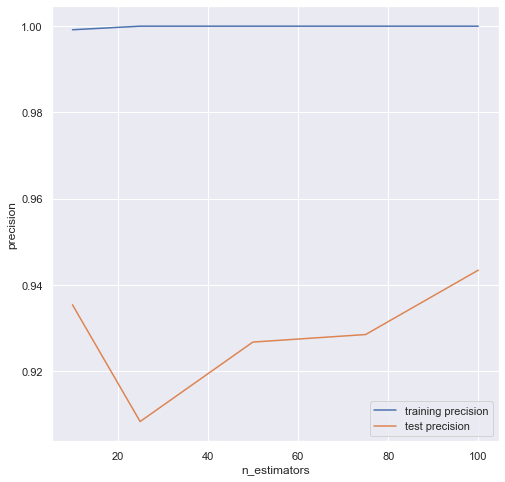


Tuning min_samples_split
Fitting 5 folds for each of 19 candidates, totalling 95 fits
0.8666468389828517
{'min_samples_split': 10}


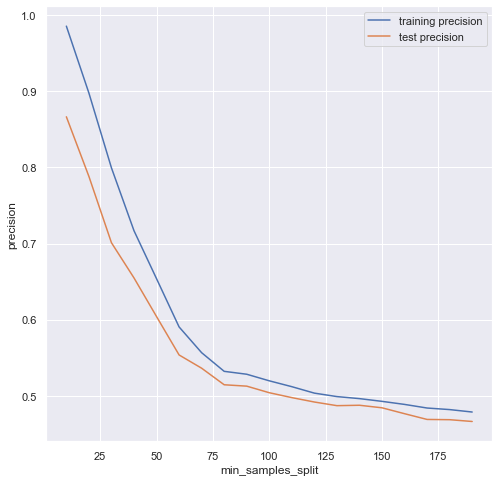


Tuning min_samples_leaf
Fitting 3 folds for each of 19 candidates, totalling 57 fits
0.6354231665565956
{'min_samples_leaf': 10}


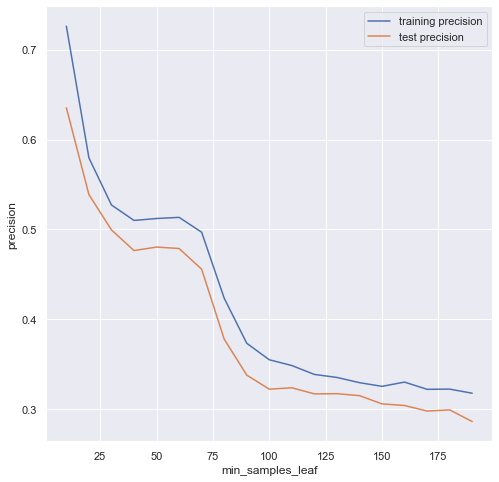


Tuning max_features
Fitting 3 folds for each of 4 candidates, totalling 12 fits
0.9208652618135377
{'max_features': 11}


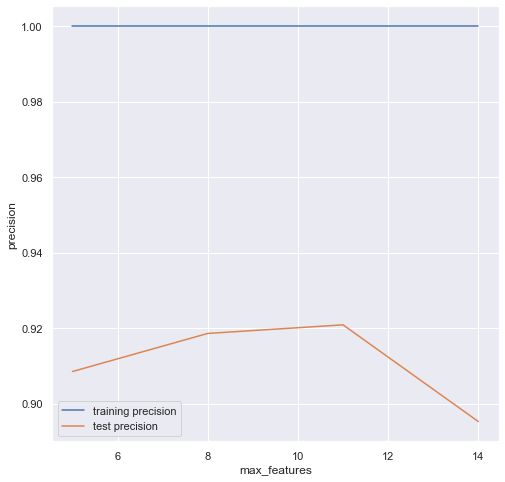



 --------------------------------------------------  Perform hyperparameter tuning  --------------------------------------------------
Fitting 3 folds for each of 75 candidates, totalling 225 fits
0.9386417445482866
{'max_depth': 20, 'min_samples_leaf': 5, 'min_samples_split': 5}
We can get accuracy of 0.9386417445482866 using {'max_depth': 20, 'min_samples_leaf': 5, 'min_samples_split': 5}


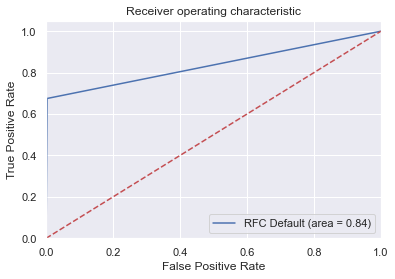

Area under curve is: 0.84
Recall for our model is: 0.68
Accuracy on test set is: 0.95
[[631   2]
 [ 38  79]]
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       633
           1       0.98      0.68      0.80       117

    accuracy                           0.95       750
   macro avg       0.96      0.84      0.88       750
weighted avg       0.95      0.95      0.94       750



 --------------------------------------------------  Plot Feat importance   --------------------------------------------------


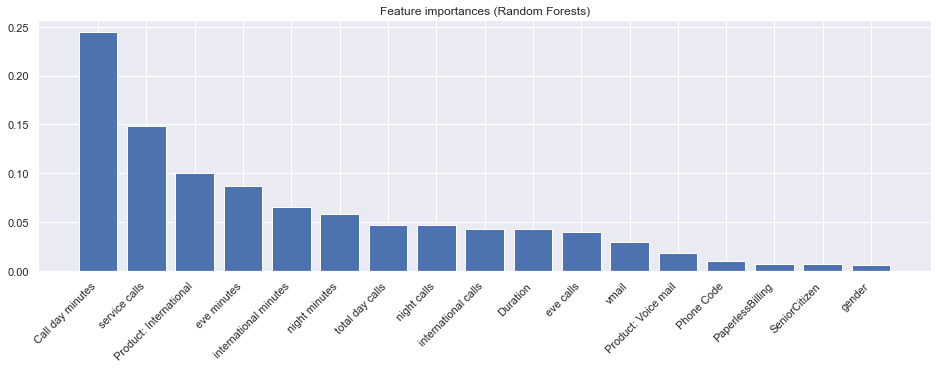

In [67]:
rf2, feats2 = Train_ML_Model(df_data[list(set(df_data.columns)-set(wieghted_feats))])

## Impact of Hyperparameter Tuning
- Accuray increase
- AUC increase
- Recall increase

## Validation Results

In [68]:
Val_Pred(df_val[list(set(df_data.columns)-set(wieghted_feats))],rf2)

Recall for our model is: 0.91
Accuracy on test set is: 0.99
[[2560    2]
 [  38  399]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2562
           1       1.00      0.91      0.95       437

    accuracy                           0.99      2999
   macro avg       0.99      0.96      0.97      2999
weighted avg       0.99      0.99      0.99      2999



# Model 3 - Remove less important feats

Index(['international calls', 'w_vmail', 'night minutes', 'w_eve calls',
       'Product: International', 'w_international calls',
       'Product: Voice mail', 'w_night minutes', 'service calls',
       'w_Call day minutes', 'international minutes', 'Call day minutes',
       'vmail', 'PaperlessBilling', 'w_international minutes', 'eve minutes'],
      dtype='object')
Classifier: dummy_classifier, Accuracy: 0.844)
Classifier: k_nearest_neighbors, Accuracy: 0.8893333333333333)
Classifier: logistic_regression, Accuracy: 0.8466666666666667)
Classifier: support_vector_machines, Accuracy: 0.8706666666666667)
Classifier: random_forest, Accuracy: 0.9466666666666667)
Classifier: gradient_boosting, Accuracy: 0.9533333333333334)


 --------------------------------------------------  Train RF Model --------------------------------------------------


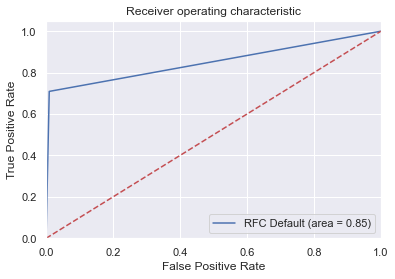

Area under curve is: 0.85
Recall for our model is: 0.71
Accuracy on test set is: 0.95
[[627   6]
 [ 34  83]]
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       633
           1       0.93      0.71      0.81       117

    accuracy                           0.95       750
   macro avg       0.94      0.85      0.89       750
weighted avg       0.95      0.95      0.94       750



 --------------------------------------------------  Perform hyperparameter tuning wrt individual parameters --------------------------------------------------

Tuning max_depth
Fitting 5 folds for each of 23 candidates, totalling 115 fits
0.9259881422924903
{'max_depth': 15}


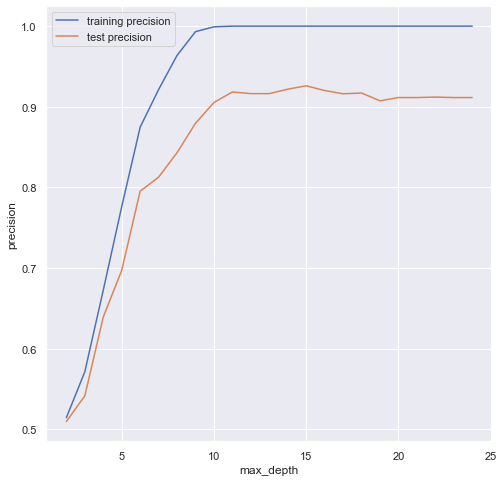


Tuning n_estimators
Fitting 5 folds for each of 5 candidates, totalling 25 fits
0.914711691816955
{'n_estimators': 10}


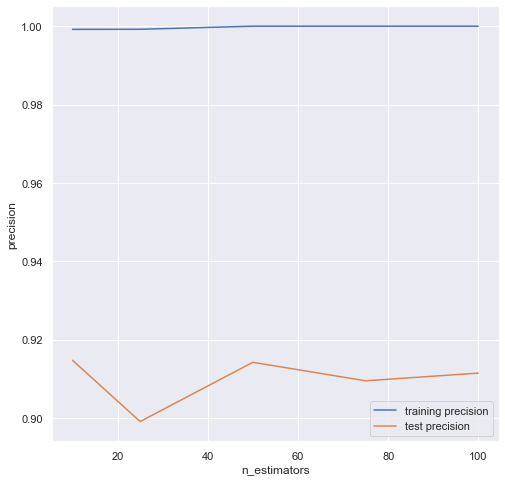


Tuning min_samples_split
Fitting 5 folds for each of 19 candidates, totalling 95 fits
0.8688477328955893
{'min_samples_split': 10}


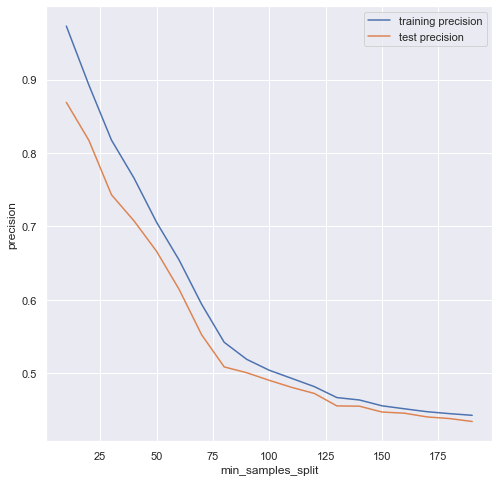


Tuning min_samples_leaf
Fitting 3 folds for each of 19 candidates, totalling 57 fits
0.7131914993874281
{'min_samples_leaf': 10}


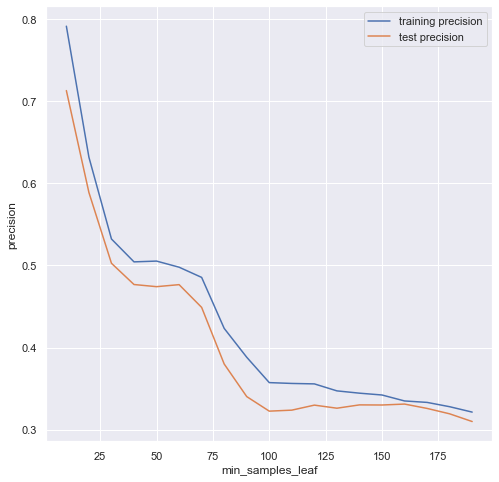


Tuning max_features
Fitting 3 folds for each of 4 candidates, totalling 12 fits
0.9167207402066812
{'max_features': 5}


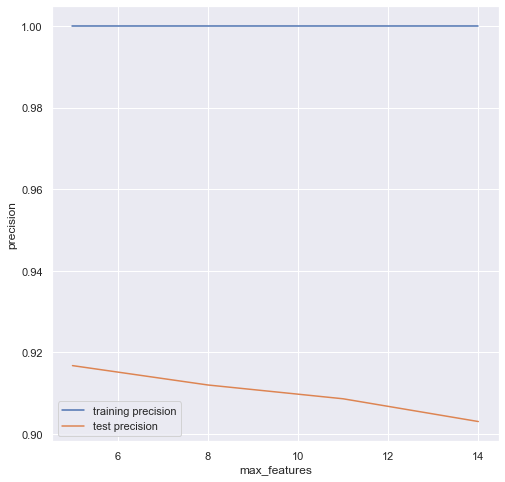



 --------------------------------------------------  Perform hyperparameter tuning  --------------------------------------------------
Fitting 3 folds for each of 75 candidates, totalling 225 fits
0.9422002670226969
{'max_depth': 15, 'min_samples_leaf': 5, 'min_samples_split': 5}
We can get accuracy of 0.9422002670226969 using {'max_depth': 15, 'min_samples_leaf': 5, 'min_samples_split': 5}


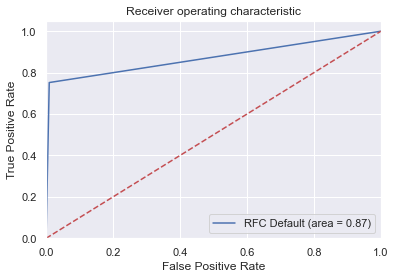

Area under curve is: 0.87
Recall for our model is: 0.75
Accuracy on test set is: 0.95
[[627   6]
 [ 29  88]]
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       633
           1       0.94      0.75      0.83       117

    accuracy                           0.95       750
   macro avg       0.95      0.87      0.90       750
weighted avg       0.95      0.95      0.95       750



 --------------------------------------------------  Plot Feat importance   --------------------------------------------------


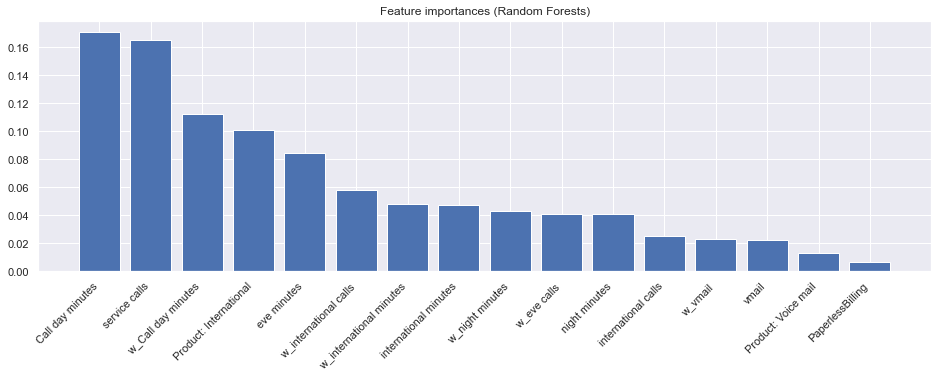

In [70]:
rf3, feats3 = Train_ML_Model(df_data[list(set(df_data.columns)-set(less_imp_feats))])

## Impact of Hyperparameter Tuning 
- AUC increase
- Recall increase

## Validation Results

In [71]:
Val_Pred(df_val[list(set(df_data.columns)-set(less_imp_feats))],rf3)

Recall for our model is: 0.93
Accuracy on test set is: 0.99
[[2556    6]
 [  30  407]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2562
           1       0.99      0.93      0.96       437

    accuracy                           0.99      2999
   macro avg       0.99      0.96      0.98      2999
weighted avg       0.99      0.99      0.99      2999



## Models performance : Model-3 > Model-2 > Model-1
Why model3 better than Model2 and Model1? 

Why Model2 better than Model1? (in terms of precision)

# END

## Save Model as Pickle File

In [ ]:
#pickle.dump(rfc, open(f'model/RF_V001.pkl', 'wb'))

## Check results wrt Validation Data Set

In [ ]:
#from get_pred import Main_Pred
#Main_Pred('8022-BECSI')